In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import edge_pydb.version
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
print('edge_pydb version:',edge_pydb.version.__version__)
from astropy.table import Table, Column
from edge_pydb.plotting import xy2hist
from matplotlib.ticker import MultipleLocator
import leopy
# sys.path.append('/Users/tonywong/Work/bin/py-package/leopy/paper/')
# import auxiliary
from scipy import stats, odr
import warnings
warnings.filterwarnings('ignore')

edge_pydb version: 1.6.3.dev0+ga840a2a.d20231120


# Determine regression lines using LeoPy

In [2]:
# limit the columns we read to avoid information overload
sspcols   = ['Name','ix','iy','fe_medflx_sm','sigstar_sm']
fluxcols  = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm','e_flux_Hbeta_sm',
             'flux_sigsfr0_sm','flux_sigsfr_corr_sm','flux_sigsfr_adopt_sm','e_flux_sigsfr_corr_sm',
             'SF_BPT_sm']
comomcols = ['Name','ix','iy','mom0_12','e_mom0_12','sigmol','e_sigmol']

# Read the tables
cofluxtab   = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coDilatedDv_smo7'])
fluxtab     = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
ssptab      = EdgeTable('edge_carma.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
cotab       = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_dil', cols=comomcols)
conomasktab = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_str', cols=['Name','ix','iy','e_mom0_12'])
print('Working on full EDGE database')
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coDilatedDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coDilatedDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)
# consolidate the tables
conomasktab['e_mom0_12'] *= nsefactor
conomasktab['e_mom0_12'].name = 'e_mom0max_12'
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
print(fluxtab.colnames)

Working on full EDGE database
Median unmasked velocity width is 860.0
Median masked velocity width is 400.0
Noise estimates will be scaled down by 0.6819943394704735
['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'flux_sigsfr0_sm', 'flux_sigsfr_corr_sm', 'flux_sigsfr_adopt_sm', 'e_flux_sigsfr_corr_sm', 'SF_BPT_sm', 'fe_medflx_sm', 'sigstar_sm', 'mom0_12', 'e_mom0_12', 'sigmol', 'e_sigmol', 'e_mom0max_12']


In [3]:
print('Good values for sigmol uncertainty:',sum(~np.isnan(fluxtab['e_sigmol'])))
print('Bad values for sigmol uncertainty:',sum(np.isnan(fluxtab['e_sigmol'])))
print('Good values for straight mom-0 uncertainty:',sum(~np.isnan(fluxtab['e_mom0max_12'])))
print('Bad values for straight mom-0 uncertainty:',sum(np.isnan(fluxtab['e_mom0max_12'])))

Good values for sigmol uncertainty: 12284
Bad values for sigmol uncertainty: 218841
Good values for straight mom-0 uncertainty: 144447
Bad values for straight mom-0 uncertainty: 86678


In [4]:
def model(p, x):
    a, b = p
    return a + b*x

def fitODR(x ,y, xerr=None, yerr=None, verbose=False):
    sorted=np.argsort(x)
    xfit = x[sorted]
    yfit = y[sorted]
    if xerr is not None:
        xerrfit = xerr[sorted]
    else:
        xerrfit = None
    if yerr is not None:
        yerrfit = yerr[sorted]
    else:
        yerrfit = None
    b, a, rval, pval, std_err = stats.linregress(xfit, yfit)
    print("\nLineregress parameters: {:.2f} + x*({:.2f}+/-{:.2f})".format(
           a, b, std_err))
    # --- scipy ODR approach
    linear = odr.Model(model)
    mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
    myodr  = odr.ODR(mydata, linear, beta0=[a,b])
    myoutput = myodr.run()
    if verbose:
        print("\n======== Results from scipy.odr =========")
        myoutput.pprint()
    c, d = myoutput.beta
    c_err, d_err = myoutput.sd_beta
    yscat = np.std(yfit-model([c, d], xfit))
    return c, c_err, d, d_err, yscat

def f_mlnlike(x):
    nt = 200
    t = np.linspace(min_t, max_t, nt)

    m = x[0]
    n = x[1]

    loc_true = np.ones((2, 1, nt))
    loc_true[0, :] = t
    loc_true[1, :] = m * t + n

    scale_true = [scale[0], x[2]]

    p_xy = like.p(loc_true, scale_true)

    m_ln_p_xy = -np.sum(np.log(scipy.integrate.simps(p_xy, axis=1)))

    #p_x = like.p(loc_true, scale_true, vars=[0])
    #m_ln_p_x = -np.sum(np.log(scipy.integrate.simps(p_x, axis=1)))
    m_ln_p_x = 0.

    return m_ln_p_xy - m_ln_p_x

In [5]:
valid = ((fluxtab['e_sigmol'] > 0) & 
         (fluxtab['fe_medflx_sm'] > 0) &
         (fluxtab['e_flux_sigsfr_corr_sm'] > 1e-4) & 
         (fluxtab['e_flux_sigsfr_corr_sm'] < 1e4) &
         (fluxtab['SF_BPT_sm'] == 1))
print(np.sum(valid),'valid uncertainties')

goodmol = valid & (fluxtab['sigmol'] > 0)
print(np.sum(goodmol),'goodmol values')
badmol = valid & ~(fluxtab['sigmol'] > 0)
print(np.sum(badmol),'badmol values')
# Negative or NaN sigmol's will be set to 1-sigma RMS value
fluxtab['sigmol'][badmol] = fluxtab['e_sigmol'][badmol]
lgmol   = np.log10(fluxtab['sigmol'][valid])
e_lgmol = (fluxtab['e_sigmol'][valid]/fluxtab['sigmol'][valid])/np.log(10)

goodsfr = valid & (fluxtab['flux_sigsfr_adopt_sm'] > 0)
print(np.sum(goodsfr),'goodsfr values')
badsfr = valid & ~(fluxtab['flux_sigsfr_adopt_sm'] > 0)
print(np.sum(badsfr),'badsfr values')
# Negative or NaN sigsfr's will be set to 1-sigma RMS value
fluxtab['flux_sigsfr_adopt_sm'][badsfr] = fluxtab['e_flux_sigsfr_corr_sm'][badsfr]
lgsfr = np.log10(fluxtab['flux_sigsfr_adopt_sm'][valid])
e_lgsfr = (fluxtab['e_flux_sigsfr_corr_sm'][valid]/fluxtab['flux_sigsfr_adopt_sm'][valid])/np.log(10)

goodstar = valid & (fluxtab['sigstar_sm'] > 0)
print(np.sum(goodstar),'goodstar values')
badstar = valid & ~(fluxtab['sigstar_sm'] > 0)
print(np.sum(badstar),'badstar values')
# Negative or NaN sigstar's will be set to a minimum value
fluxtab['sigstar_sm'][badstar] = np.min(fluxtab['sigstar_sm'][goodstar])
lgstar = np.log10(fluxtab['sigstar_sm'][valid])
e_lgstar = fluxtab['fe_medflx_sm'][valid]/np.log(10)

8279 valid uncertainties
8270 goodmol values
9 badmol values
8279 goodsfr values
0 badsfr values
8279 goodstar values
0 badstar values


# Compare fits for resolved relations

Number of rows dropped b/c not detected in either axis: 878
Slope, intercept: 0.8627735786245586 0.1587113970200984
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28670.638070103043
            Iterations: 17
            Function evaluations: 87
            Gradient evaluations: 17
Maximum likelihood parameters: [0.762 0.3 0.271]

Lineregress parameters: 0.16 + x*(0.86+/-0.01)


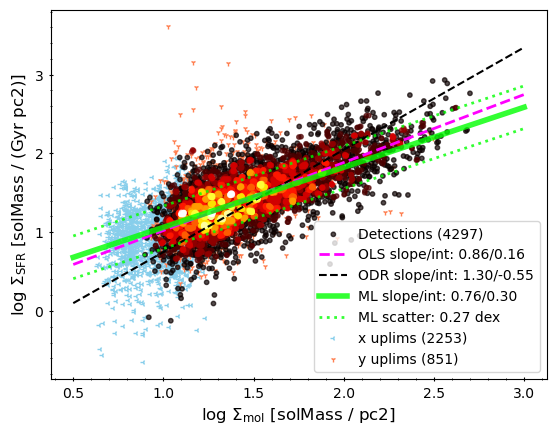

Number of rows dropped b/c not detected in either axis: 39
Slope, intercept: 0.6371677475377454 -0.061376791895983995
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28582.669035435854
            Iterations: 27
            Function evaluations: 139
            Gradient evaluations: 27
Maximum likelihood parameters: [0.986 -1.02 0.308]

Lineregress parameters: -0.06 + x*(0.64+/-0.01)


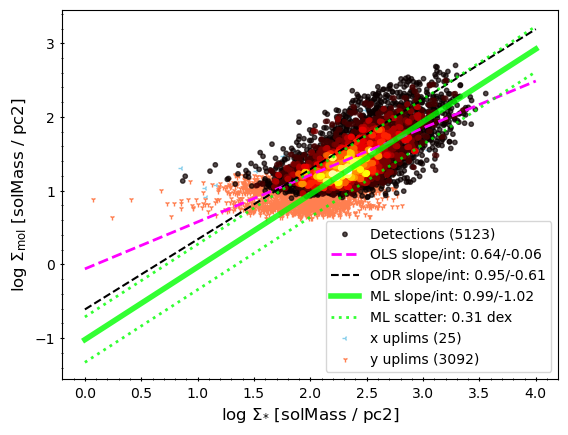

Number of rows dropped b/c not detected in either axis: 30
Slope, intercept: 0.7994752712733818 -0.5408777995376224
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29034.66820912071
            Iterations: 21
            Function evaluations: 102
            Gradient evaluations: 21
Maximum likelihood parameters: [0.848 -0.702 0.322]

Lineregress parameters: -0.54 + x*(0.80+/-0.01)


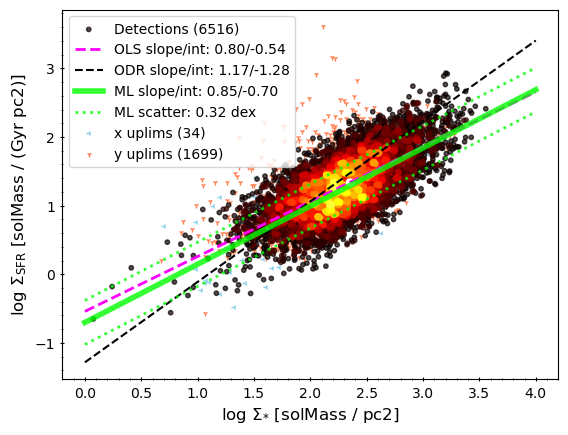

In [6]:
xlbl = [r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{*}$', r'log $\Sigma_{*}$']
ylbl = [r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{\rm SFR}$']

for imode in range(3):
    if imode == 0:
        xrange = [0.5, 3]
        lgx = lgmol
        lgy = lgsfr
        e_lgx = e_lgmol
        e_lgy = e_lgsfr
        l_lgx = np.log10(3*fluxtab['e_sigmol'][valid])
        l_lgy = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    elif imode == 1:
        xrange = [0, 4]
        lgx = lgstar
        lgy = lgmol
        e_lgx = e_lgstar
        e_lgy = e_lgmol
        l_lgx = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgy = np.log10(3*fluxtab['e_sigmol'][valid])
    elif imode == 2:
        xrange = [0, 4]
        lgx = lgstar
        lgy = lgsfr
        e_lgx = e_lgstar
        e_lgy = e_lgsfr
        l_lgx = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgy = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    c_lgx = (e_lgx > 1/(3*np.log(10)))
    c_lgy = (e_lgy > 1/(3*np.log(10)))
        
    df = pd.DataFrame(np.array([lgx, e_lgx, c_lgx, l_lgx,
                                lgy, e_lgy, c_lgy, l_lgy]).T,
                      columns=['v0', 'e_v0', 'c_v0', 'l_v0',
                               'v1', 'e_v1', 'c_v1', 'l_v1'])

    # Drop pixels that are non-detected in both tracers
    nrows = len(df)
    df = df[(df['c_v0'] < 1) | (df['c_v1'] < 1)]
    print('Number of rows dropped b/c not detected in either axis:', nrows - len(df))

    # Simple regression based on detections
    det = (c_lgx == 0) & (c_lgy == 0)
    slope, intercept, r, p, se = stats.linregress(lgx[det],lgy[det])
    print('Slope, intercept:', slope, intercept)

    min_t = xrange[0]
    max_t = xrange[1]
    scale = np.array([0.01, 1.])

    obs = leopy.Observation(df, 'test', verbosity=0)

    ## -- set up Likelihood and find maximum likelihood parameters
    like = leopy.Likelihood(obs, p_true='norm', p_cond='norm',
                            verbosity=-1)


    bounds = scipy.optimize.Bounds([0, -5, 1e-3],
                                   [5,  5, 10.])
    print('Running ML optimization ...')

    optres = scipy.optimize.minimize(f_mlnlike, [0.9, 0.1, 0.5],
                                     bounds=bounds, method='SLSQP',
                                     options={'disp': True,
                                              'ftol': 1e-12})

    print('Maximum likelihood parameters: [{:.3g} {:.3g} '
          '{:.3g}]'.format(*optres.x))

    ## -- plot fit results
    det = (c_lgx == 0) & (c_lgy == 0)
    x_det, y_det, z_det, *hist = xy2hist(lgx[det], lgy[det], log=False)
    plt.scatter(x_det, y_det, c=z_det, s=10, cmap='hot', alpha=0.7,
                label=f'Detections ({np.sum(det)})')
    xmod = np.linspace(min_t, max_t, 10)
    plt.plot(xmod, intercept + slope * xmod, ls='--', color='magenta', 
             label=f'OLS slope/int: {slope:.2f}/{intercept:.2f}', lw=2, zorder=2)
    ycept, e_ycept, slp, e_slp, yscat = fitODR(lgx[det], lgy[det], e_lgx[det], e_lgy[det])
    plt.plot(xmod, model([ycept, slp], xmod), linestyle='--', color='k', zorder=2,
             label=f'ODR slope/int: {slp:.2f}/{ycept:.2f}')
    plt.plot(xmod, optres.x[0] * xmod + optres.x[1], '-', 
             color='lime', lw=4, alpha=0.8, label=f'ML slope/int: {optres.x[0]:.2f}/{optres.x[1]:.2f}')
    plt.plot(xmod, optres.x[0] * xmod + optres.x[1] + optres.x[2], ':', 
             color='lime', lw=2, alpha=0.8, label=f'ML scatter: {optres.x[2]:.2f} dex')
    plt.plot(xmod, optres.x[0] * xmod + optres.x[1] - optres.x[2], ':', 
             color='lime', lw=2, alpha=0.8)
    cenx = (c_lgx == 1) & (c_lgy == 0)
    plt.plot(l_lgx[cenx], lgy[cenx], marker='3', 
             color='skyblue', ls='none', markersize=4, zorder=-4,
             label=f'x uplims ({np.sum(cenx)})')
    ceny = (c_lgx == 0) & (c_lgy == 1)
    plt.plot(lgx[ceny], l_lgy[ceny], marker='1', 
             color='coral', ls='none', markersize=4, zorder=-3,
             label=f'y uplims ({np.sum(ceny)})')
    plt.tick_params(axis='both', which='major', direction='inout',labelsize=10)
    plt.tick_params(axis='both', which='minor', direction='inout',labelsize=10)
    plt.minorticks_on()
    plt.xlabel(xlbl[imode]+' ['+str(lgx.unit)+']', fontsize='large')
    plt.ylabel(ylbl[imode]+' ['+str(lgy.unit)+']', fontsize='large')
    plt.legend(loc='best')
    plt.show()

# Plot the three relations together

Number of rows dropped b/c not detected in either axis: 878
Slope, intercept: 0.8627735786245586 0.1587113970200984
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28670.638070103043
            Iterations: 18
            Function evaluations: 99
            Gradient evaluations: 18
Maximum likelihood parameters: [0.762 0.3 0.271]
Number of rows dropped b/c not detected in either axis: 39
Slope, intercept: 0.6371677475377454 -0.061376791895983995
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -28582.6690354358
            Iterations: 20
            Function evaluations: 108
            Gradient evaluations: 20
Maximum likelihood parameters: [0.986 -1.02 0.308]
Number of rows dropped b/c not detected in either axis: 30
Slope, intercept: 0.7994752712733818 -0.5408777995376224
Running ML optimization ...
Optimization terminated successfully    (Exit

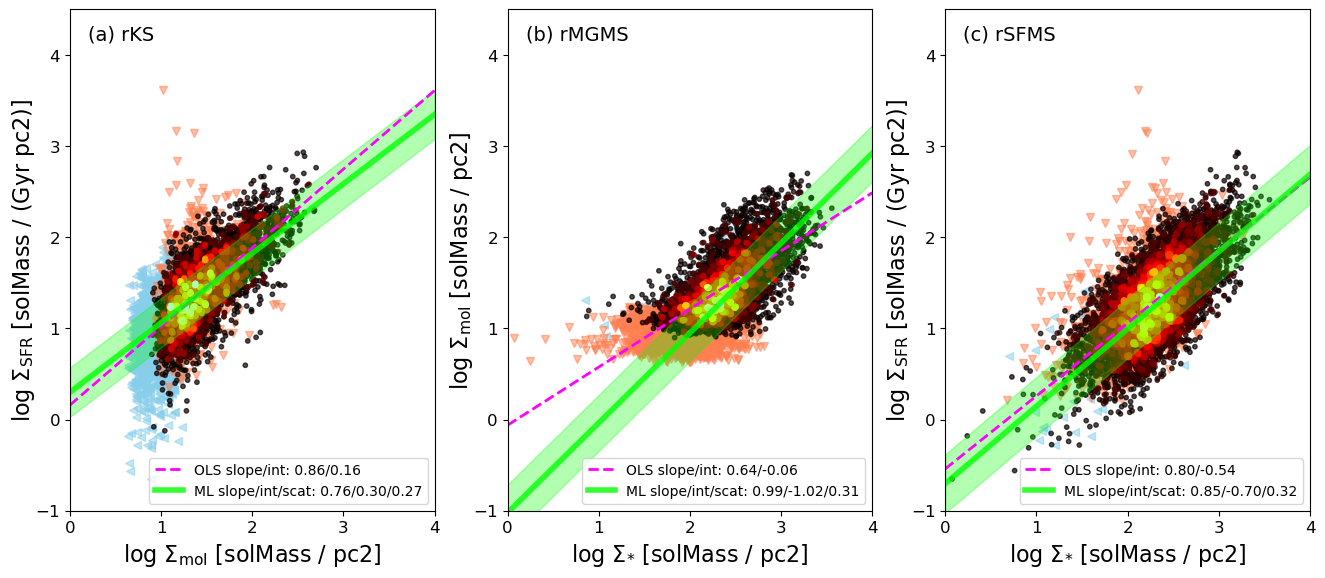

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16,8), sharey=False)
plt.subplots_adjust(wspace=0.2)

xlbl = [r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{*}$', r'log $\Sigma_{*}$']
ylbl = [r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{\rm SFR}$']

for i in range(3):
    if i == 0:
        xrange = [0.5, 3]
        lgx = lgmol
        lgy = lgsfr
        e_lgx = e_lgmol
        e_lgy = e_lgsfr
        l_lgx = np.log10(3*fluxtab['e_sigmol'][valid])
        l_lgy = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    elif i == 1:
        xrange = [0, 4]
        lgx = lgstar
        lgy = lgmol
        e_lgx = e_lgstar
        e_lgy = e_lgmol
        l_lgx = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgy = np.log10(3*fluxtab['e_sigmol'][valid])
    elif i == 2:
        xrange = [0, 4]
        lgx = lgstar
        lgy = lgsfr
        e_lgx = e_lgstar
        e_lgy = e_lgsfr
        l_lgx = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgy = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    c_lgx = (e_lgx > 1/(3*np.log(10)))
    c_lgy = (e_lgy > 1/(3*np.log(10)))
        
    df = pd.DataFrame(np.array([lgx, e_lgx, c_lgx, l_lgx,
                                lgy, e_lgy, c_lgy, l_lgy]).T,
                      columns=['v0', 'e_v0', 'c_v0', 'l_v0',
                               'v1', 'e_v1', 'c_v1', 'l_v1'])

    # Drop pixels that are non-detected in both tracers
    nrows = len(df)
    # Commented out: only consider SFR detections since upper lims seem suspect
    #if i == 0 or i == 2:
    #    df = df[(df['c_v1'] < 1)]
    #else:
    #    df = df[(df['c_v0'] < 1) | (df['c_v1'] < 1)]
    df = df[(df['c_v0'] < 1) | (df['c_v1'] < 1)]
    print('Number of rows dropped b/c not detected in either axis:', nrows - len(df))

    # Simple regression based on detections
    det = (c_lgx == 0) & (c_lgy == 0)
    slope, intercept, r, p, se = stats.linregress(lgx[det],lgy[det])
    print('Slope, intercept:', slope, intercept)

    min_t = xrange[0]
    max_t = xrange[1]
    scale = np.array([0.01, 1.])

    obs = leopy.Observation(df, 'test', verbosity=0)

    ## -- set up Likelihood and find maximum likelihood parameters
    like = leopy.Likelihood(obs, p_true='norm', p_cond='norm',
                            verbosity=-1)


    bounds = scipy.optimize.Bounds([0, -5, 1e-3],
                                   [5,  5, 10.])
    print('Running ML optimization ...')

    optres = scipy.optimize.minimize(f_mlnlike, [1, -0.5, 0.5],
                                     bounds=bounds, method='SLSQP',
                                     options={'disp': True,
                                              'ftol': 1e-12})

    print('Maximum likelihood parameters: [{:.3g} {:.3g} '
          '{:.3g}]'.format(*optres.x))

    ## -- plot fit results
    det = (c_lgx == 0) & (c_lgy == 0)
    x_det, y_det, z_det, *hist = xy2hist(lgx[det], lgy[det], log=False)
    axs[i].scatter(x_det, y_det, c=z_det, s=10, cmap='hot', alpha=0.7)
    axs[i].set_xlim( 0, 4)
    axs[i].set_ylim(-1, 4.5)
    axs[i].set_aspect('equal')
    xlims = axs[i].get_xlim()
    xmod = np.linspace(xlims[0],xlims[1], 10)
    axs[i].plot(xmod, intercept + slope * xmod, ls='--', color='magenta', 
             label=f'OLS slope/int: {slope:.2f}/{intercept:.2f}', lw=2, zorder=2)
#     ycept, e_ycept, slp, e_slp, yscat = fitODR(lgx[det], lgy[det], e_lgx[det], e_lgy[det])
#     axs[i].plot(xmod, model([ycept, slp], xmod), linestyle=':', color='magenta', 
#                 zorder=2, lw=3, label=f'ODR slope/int: {slp:.2f}/{ycept:.2f}')
    axs[i].plot(xmod, optres.x[0] * xmod + optres.x[1], '-', color='lime', lw=4, alpha=0.8, 
                label=f'ML slope/int/scat: {optres.x[0]:.2f}/{optres.x[1]:.2f}/{optres.x[2]:.2f}')
    axs[i].fill_between(xmod, optres.x[0] * xmod + optres.x[1] - optres.x[2],
                        optres.x[0] * xmod + optres.x[1] + optres.x[2], color='lime', 
                        alpha=0.3)
    cenx = (c_lgx == 1) & (c_lgy == 0)
    axs[i].plot(l_lgx[cenx], lgy[cenx], marker='<', 
             color='skyblue', ls='none', markersize=6, alpha=0.5, zorder=-4)
    ceny = (c_lgx == 0) & (c_lgy == 1)
    axs[i].plot(lgx[ceny], l_lgy[ceny], marker='v', 
             color='coral', ls='none', markersize=6, alpha=0.5, zorder=-3)

    if i == 0:
        axs[i].text(0.05,0.95,'(a) rKS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    if i == 1:
        axs[i].text(0.05,0.95,'(b) rMGMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    elif i == 2:
        axs[i].text(0.05,0.95,'(c) rSFMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    axs[i].set_xlabel(xlbl[i]+' ['+str(lgx.unit)+']', fontsize=16)
    axs[i].set_ylabel(ylbl[i]+' ['+str(lgy.unit)+']', fontsize=16, labelpad=-1)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))
    axs[i].yaxis.set_major_locator(MultipleLocator(1))
    axs[i].legend(fontsize='medium', loc='lower right')
plt.savefig('threeviews_leopy.pdf',bbox_inches='tight')

# Reverse the axes

Number of rows dropped b/c not detected in either axis: 1729
Slope, intercept: 0.6260658777666103 0.5874539548613942
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -23248.393445019236
            Iterations: 31
            Function evaluations: 164
            Gradient evaluations: 31
Maximum likelihood parameters: [0.865 0.141 0.262]

Lineregress parameters: 0.59 + x*(0.63+/-0.01)
Number of rows dropped b/c not detected in either axis: 39
Slope, intercept: 0.6511654984669555 1.4469581853908888
Running ML optimization ...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -32904.44104183425
            Iterations: 20
            Function evaluations: 101
            Gradient evaluations: 19
Maximum likelihood parameters: [0.624 1.49 0.248]

Lineregress parameters: 1.45 + x*(0.65+/-0.01)
Number of rows dropped b/c not detected in either axis: 1729
Slope, intercept: 0.59635039176

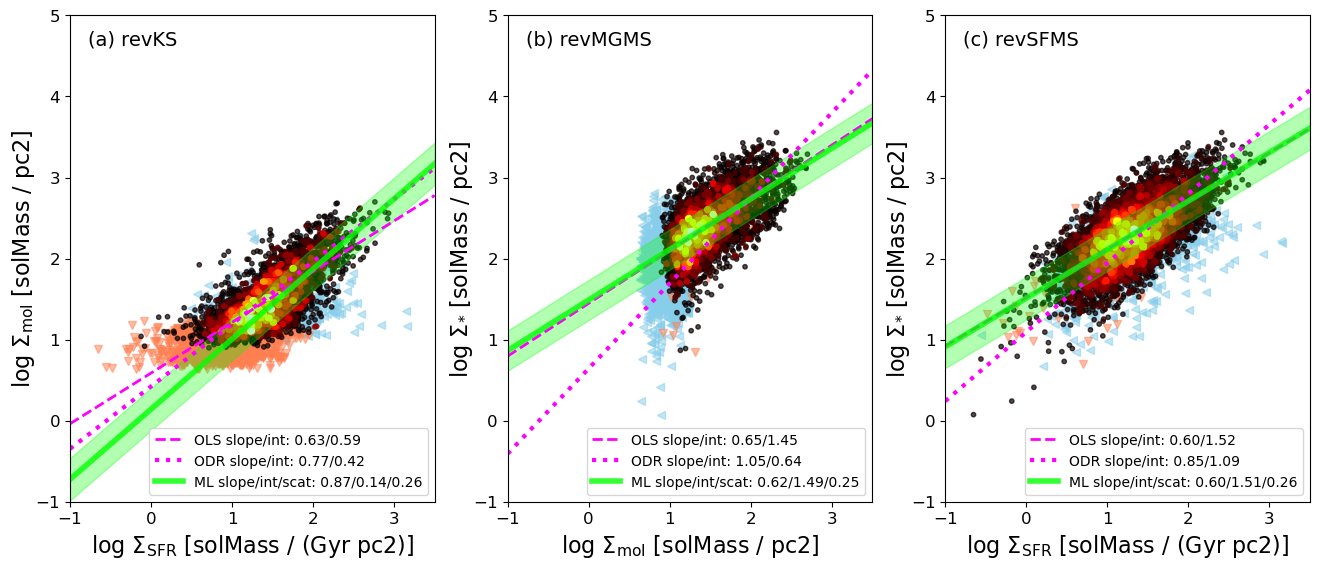

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,8), sharey=False)
plt.subplots_adjust(wspace=0.2)

xlbl = [r'log $\Sigma_{\rm SFR}$', r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{\rm SFR}$']
ylbl = [r'log $\Sigma_{\rm mol}$', r'log $\Sigma_{*}$', r'log $\Sigma_{*}$']

for i in range(3):
    if i == 0:
        xrange = [-1, 3]
        lgy = lgmol
        lgx = lgsfr
        e_lgy = e_lgmol
        e_lgx = e_lgsfr
        l_lgy = np.log10(3*fluxtab['e_sigmol'][valid])
        l_lgx = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    elif i == 1:
        xrange = [0.5, 3]
        lgy = lgstar
        lgx = lgmol
        e_lgy = e_lgstar
        e_lgx = e_lgmol
        l_lgy = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgx = np.log10(3*fluxtab['e_sigmol'][valid])
    elif i == 2:
        xrange = [-1, 3]
        lgy = lgstar
        lgx = lgsfr
        e_lgy = e_lgstar
        e_lgx = e_lgsfr
        l_lgy = np.log10(3*fluxtab['fe_medflx_sm'][valid]*fluxtab['sigstar_sm'][valid])
        l_lgx = np.log10(3*fluxtab['e_flux_sigsfr_corr_sm'][valid])
    c_lgx = (e_lgx > 1/(3*np.log(10)))
    c_lgy = (e_lgy > 1/(3*np.log(10)))
        
    df = pd.DataFrame(np.array([lgx, e_lgx, c_lgx, l_lgx,
                                lgy, e_lgy, c_lgy, l_lgy]).T,
                      columns=['v0', 'e_v0', 'c_v0', 'l_v0',
                               'v1', 'e_v1', 'c_v1', 'l_v1'])

    # Drop pixels that are non-detected in both tracers
    nrows = len(df)
    if i == 0 or i == 2:
        df = df[(df['c_v0'] < 1)]
    else:
        df = df[(df['c_v0'] < 1) | (df['c_v1'] < 1)]
    df = df[(df['c_v0'] < 1) | (df['c_v1'] < 1)]
    print('Number of rows dropped b/c not detected in either axis:', nrows - len(df))

    # Simple regression based on detections
    det = (c_lgx == 0) & (c_lgy == 0)
    slope, intercept, r, p, se = stats.linregress(lgx[det],lgy[det])
    print('Slope, intercept:', slope, intercept)

    min_t = xrange[0]
    max_t = xrange[1]
    scale = np.array([0.01, 1.])

    obs = leopy.Observation(df, 'test', verbosity=0)

    ## -- set up Likelihood and find maximum likelihood parameters
    like = leopy.Likelihood(obs, p_true='norm', p_cond='norm',
                            verbosity=-1)

    bounds = scipy.optimize.Bounds([0, -5, 1e-3],
                                   [5,  5, 10.])
    print('Running ML optimization ...')

    optres = scipy.optimize.minimize(f_mlnlike, [1, 1, 0.5],
                                     bounds=bounds, method='SLSQP',
                                     options={'disp': True,
                                              'ftol': 1e-12})

    print('Maximum likelihood parameters: [{:.3g} {:.3g} '
          '{:.3g}]'.format(*optres.x))

    ## -- plot fit results
    det = (c_lgx == 0) & (c_lgy == 0)
    x_det, y_det, z_det, *hist = xy2hist(lgx[det], lgy[det], log=False)
    axs[i].scatter(x_det, y_det, c=z_det, s=10, cmap='hot', alpha=0.7)
    axs[i].set_xlim(-1, 3.5)
    axs[i].set_ylim(-1, 5)
    axs[i].set_aspect('equal')
    xlims = axs[i].get_xlim()
    xmod = np.linspace(xlims[0],xlims[1], 10)
    axs[i].plot(xmod, intercept + slope * xmod, ls='--', color='magenta', 
             label=f'OLS slope/int: {slope:.2f}/{intercept:.2f}', lw=2, zorder=2)
    ycept, e_ycept, slp, e_slp, yscat = fitODR(lgx[det], lgy[det], e_lgx[det], e_lgy[det])
    axs[i].plot(xmod, model([ycept, slp], xmod), linestyle=':', color='magenta', 
                zorder=2, lw=3, label=f'ODR slope/int: {slp:.2f}/{ycept:.2f}')
    axs[i].plot(xmod, optres.x[0] * xmod + optres.x[1], '-', color='lime', lw=4, alpha=0.8, 
                label=f'ML slope/int/scat: {optres.x[0]:.2f}/{optres.x[1]:.2f}/{optres.x[2]:.2f}')
    axs[i].fill_between(xmod, optres.x[0] * xmod + optres.x[1] - optres.x[2],
                        optres.x[0] * xmod + optres.x[1] + optres.x[2], color='lime', 
                        alpha=0.3)
    cenx = (c_lgx == 1) & (c_lgy == 0)
    axs[i].plot(l_lgx[cenx], lgy[cenx], marker='<', 
             color='skyblue', ls='none', markersize=6, alpha=0.5, zorder=-4)
    ceny = (c_lgx == 0) & (c_lgy == 1)
    axs[i].plot(lgx[ceny], l_lgy[ceny], marker='v', 
             color='coral', ls='none', markersize=6, alpha=0.5, zorder=-3)

    if i == 0:
        axs[i].text(0.05,0.95,'(a) revKS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    if i == 1:
        axs[i].text(0.05,0.95,'(b) revMGMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    elif i == 2:
        axs[i].text(0.05,0.95,'(c) revSFMS',size=14,ha='left',va='center',transform=axs[i].transAxes)
    axs[i].set_xlabel(xlbl[i]+' ['+str(lgx.unit)+']', fontsize=16)
    axs[i].set_ylabel(ylbl[i]+' ['+str(lgy.unit)+']', fontsize=16, labelpad=-1)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))
    axs[i].yaxis.set_major_locator(MultipleLocator(1))
    axs[i].legend(fontsize='medium', loc='lower right')
plt.savefig('threeviews_leopy_rev.pdf',bbox_inches='tight')